In [89]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

import torchclustermetrics 
reload(torchclustermetrics)
from torchclustermetrics import silhouette

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans;

In [90]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  
 0   550.61346   15.421524  18.445875  
 1   905.11600   14.925031  31.019386  
 2   596.05396   14.681485  22.270780  
 3   414.38370   19.306356  16.183300  
 4   273.81440   16.112896  26.251837  ,
 (43775350, 8))

In [91]:
# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

In [92]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [93]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [94]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [95]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=5)
clustering.xenium_spot_data.obsm["X_pca"].shape

(6138, 5)

In [96]:
def spatial_loss(model, guide, data, original_positions, batch_size=256, weight=100.0, sigma=1.0, *args, **kwargs):

    elbo_loss_fn = Trace_ELBO(num_particles=10).differentiable_loss
    elbo_loss = elbo_loss_fn(model, guide, data, *args, **kwargs)
    
    def smoothness_loss(cluster_probs, original_positions, sigma):
        pairwise_distances = torch.cdist(original_positions, original_positions, p=2)
        adjacency_matrix = torch.exp(-pairwise_distances**2 / (2 * sigma**2))
        cluster_probs = F.softmax(cluster_probs, dim=1)
        # cluster_probs = F.gumbel_softmax(cluster_probs, tau=0.25, dim=1)
        diffs = cluster_probs.unsqueeze(1) - cluster_probs.unsqueeze(0)
        smoothness_loss_value = torch.sum(adjacency_matrix * torch.sum(diffs**2, dim=-1))
        return smoothness_loss_value
    
    with pyro.plate("data", len(original_positions), subsample_size=batch_size) as ind:
        cluster_probs = (pyro.param("cluster_concentration_params_q")[ind])
        positions = original_positions[ind]
    
    spatial_loss_value = smoothness_loss(cluster_probs, positions, sigma)
    
    total_loss = elbo_loss + weight * spatial_loss_value
    
    # print(f"ELBO: {elbo_loss.item()}, SPATIAL: {weight * spatial_loss_value.item()}, CUSTOM: {total_loss.item()}")

    return total_loss

In [97]:
NUM_CLUSTERS = 6
BATCH_SIZE = 512
BATCH_SIZE = clustering.xenium_spot_data.X.shape[0]

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

In [98]:
spatial_pca = np.concatenate((clustering.xenium_spot_data.obs[["x_location", "y_location"]], clustering.xenium_spot_data.obsm["X_pca"]), axis=1)
spatial_pca = StandardScaler().fit_transform(spatial_pca)

In [99]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS).fit(spatial_pca)

In [100]:
kmeans_initial_clusters = kmeans.predict(spatial_pca)

In [101]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [102]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(kmeans_initial_clusters.astype(int)) + 1

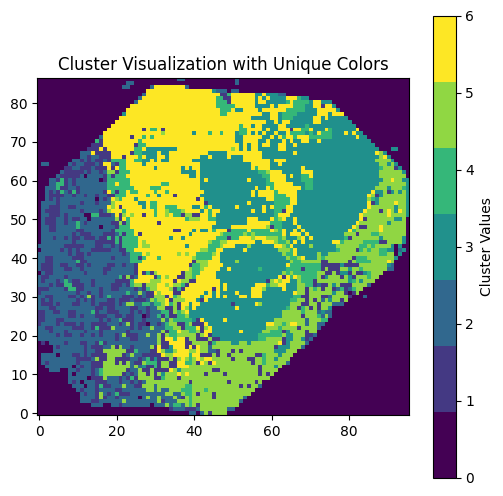

In [103]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

In [104]:
concentration_priors = torch.tensor(pd.get_dummies(kmeans_initial_clusters, dtype=float).to_numpy())
concentration_w_locations = torch.cat((torch.tensor(clustering.xenium_spot_data.obs[["row", "col"]].to_numpy()), concentration_priors), dim=1)
concentration_w_locations

tensor([[19.,  0.,  0.,  ...,  0.,  0.,  0.],
        [20.,  0.,  0.,  ...,  0.,  0.,  0.],
        [21.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [58., 95.,  0.,  ...,  0.,  0.,  0.],
        [59., 95.,  0.,  ...,  0.,  0.,  0.],
        [60., 95.,  0.,  ...,  0.,  0.,  0.]], dtype=torch.float64)

In [105]:
spatial_concentration_priors = concentration_priors.clone()
for concentration, spatial_concentration in zip(concentration_w_locations, spatial_concentration_priors):
    row, col = concentration[:2]
    
    # Apply the conditions for neighborhood
    is_row_near = (concentration_w_locations[:, 0] >= (row - 1)) & (concentration_w_locations[:, 0] <= (row + 1))
    is_col_near = (concentration_w_locations[:, 1] >= (col - 1)) & (concentration_w_locations[:, 1] <= (col + 1))
    
    # Combine the row and column conditions
    neighborhood_mask = is_row_near & is_col_near
    
    # Select the neighborhood based on the mask
    neighborhood = concentration_priors[neighborhood_mask]
    
    # Compute the mean of the data columns in the neighborhood
    mean_values = neighborhood.mean(dim=0)
    
    # Assign the mean back to the corresponding locations in the original tensor (modify this as needed)
    spatial_concentration += mean_values

In [106]:
concentration_priors = spatial_concentration_priors
concentration_priors += torch.distributions.half_normal.HalfNormal(0.2).sample((concentration_priors.shape))
torch.round(concentration_priors, decimals=4)

tensor([[2.1720e-01, 1.9579e+00, 2.1300e-02, 8.4800e-02, 1.9000e-03, 1.4690e-01],
        [7.0000e-04, 2.0544e+00, 1.1970e-01, 1.1880e-01, 9.5100e-02, 2.8230e-01],
        [1.0210e-01, 2.5426e+00, 2.0050e-01, 4.3500e-02, 1.1120e-01, 1.3930e-01],
        ...,
        [9.9600e-02, 1.8980e-01, 1.5264e+00, 2.2480e-01, 5.5170e-01, 2.6320e-01],
        [5.6900e-02, 1.2270e-01, 2.1012e+00, 4.1160e-01, 3.8720e-01, 9.2200e-02],
        [4.3950e-01, 1.6660e-01, 1.8046e+00, 1.0920e-01, 4.3330e-01, 3.2680e-01]],
       dtype=torch.float64)

In [107]:
# Load the data (5 PCs for each spot)
data = torch.tensor(clustering.xenium_spot_data.obsm["X_pca"]).float()

In [108]:
# IF NOT USING PCA, USE ALL EXPRESSIONS
# data = torch.tensor(clustering.xenium_spot_data.X).float()

In [109]:
def model(data):
    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_concentration_priors))
        
        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        
        # Likelihood of data given cluster assignments
        pyro.sample("obs", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs).to_event(1), obs=batch_data)

def guide(data):
    MIN_CONCENTRATION = 0.1
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", torch.ones(data.size(0), NUM_CLUSTERS), constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    cluster_means_q = pyro.param("cluster_means_q", torch.randn(NUM_CLUSTERS, data.size(1)))
    cluster_scales_q = pyro.param("cluster_scales_q", torch.ones(NUM_CLUSTERS, data.size(1)), constraint=dist.constraints.positive)
    
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind]

        # pyro.sample("cluster_probs", dist.Categorical(batch_cluster_probs_q))
        pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))
        pyro.sample("cluster_means", dist.Normal(cluster_means_q, 0.1).to_event(2))
        pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 0.1).to_event(2))

In [110]:
from pyro.optim import PyroOptim, PyroLRScheduler
from torch.optim import Adam, SGD, lr_scheduler

starting_lr = 0.001
ending_lr = 0.00001
N_STEPS = 10000

# Setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = PyroOptim(Adam, adam_params)
scheduler = PyroLRScheduler(lr_scheduler.StepLR, {'optimizer': Adam, 'optim_args': {'lr': starting_lr, "betas": (0.90, 0.999)}, 'step_size': 1, 'gamma': (ending_lr / starting_lr) ** (1 / N_STEPS)})

scheduler = PyroLRScheduler(lr_scheduler.StepLR, {'optimizer': SGD, 'optim_args': {'lr': starting_lr}, 'step_size': 1, 'gamma': (ending_lr / starting_lr) ** (1 / N_STEPS)})

In [111]:
original_positions = torch.tensor(clustering.xenium_spot_data.obs[["row", "col"]].to_numpy())
# original_positions /= original_positions.max()
original_positions = (original_positions - original_positions.mean(dim=0)) / original_positions.std(dim=0)

In [112]:
# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=lambda model, guide, data, original_positions: spatial_loss(model, guide, data, original_positions))

In [113]:
# Do gradient steps
for step in range(N_STEPS):
    loss = svi.step(data, original_positions)
    svi.optim.step()
    if step % 100 == 0:
        print(f"Step {step} : loss = {round(loss, 4)}")
        # Access the underlying PyTorch scheduler
        # Assuming that we are dealing with one optimizer and scheduler
        pytorch_scheduler = next(iter(scheduler.optim_objs.values()))

        # Get the last learning rate
        current_lr = pytorch_scheduler.get_last_lr()[0]  # Get the last learning rate of the first param group
        print(f"Current learning rate: {current_lr}")

KeyboardInterrupt: 

In [ ]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q))
cluster_concentration_params_q = cluster_concentration_params_q.detach().numpy()

cluster_assignments_q = cluster_probs_q.argmax(dim=1)
cluster_means_q = pyro.param("cluster_means_q").detach().numpy()
cluster_scales_q = pyro.param("cluster_scales_q").detach().numpy()

# Output the learned cluster probabilities for each data point
print(cluster_assignments_q, cluster_probs_q)

tensor([2, 2, 2,  ..., 2, 2, 2]) tensor([[5.8128e-02, 9.7927e-02, 8.4394e-01, 1.8021e-06, 7.2506e-30, 5.6466e-22],
        [1.1755e-38, 6.2486e-02, 8.2157e-01, 1.2421e-02, 3.0963e-15, 1.0353e-01],
        [5.9465e-03, 2.1109e-05, 9.9402e-01, 1.6080e-05, 3.1513e-17, 1.1755e-38],
        ...,
        [3.3526e-14, 9.6074e-21, 9.9833e-01, 1.6731e-03, 1.9861e-17, 1.1755e-38],
        [3.4162e-06, 2.0555e-01, 7.9444e-01, 6.7461e-07, 3.5324e-21, 2.2723e-06],
        [4.9690e-14, 6.0569e-07, 8.9417e-01, 9.6841e-02, 2.2246e-13, 8.9873e-03]],
       grad_fn=<_DirichletBackward>)


In [ ]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
cluster_probs_q = []
for i in range(15):
    cluster_probs_q_i = pyro.sample(f"cluster_probs_{i}", dist.Dirichlet(cluster_concentration_params_q))
    cluster_probs_q.append(cluster_probs_q_i)
cluster_concentration_params_q = cluster_concentration_params_q.detach().numpy()
cluster_probs_q = torch.stack(cluster_probs_q, dim=-1)
print(cluster_probs_q.shape)
list(cluster_probs_q.mean(dim=(0,2)))

torch.Size([7312, 6, 15])


[tensor(0.1820, grad_fn=<UnbindBackward0>),
 tensor(0.1604, grad_fn=<UnbindBackward0>),
 tensor(0.2489, grad_fn=<UnbindBackward0>),
 tensor(0.1267, grad_fn=<UnbindBackward0>),
 tensor(0.1520, grad_fn=<UnbindBackward0>),
 tensor(0.1300, grad_fn=<UnbindBackward0>)]

(array([1273.,    0., 1189.,    0., 1785.,    0.,  956.,    0., 1146.,
         963.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

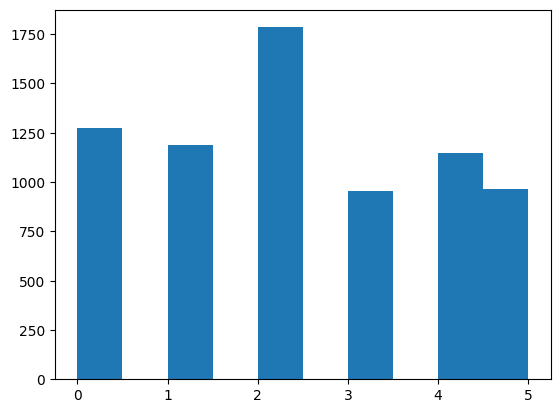

In [ ]:
plt.hist(cluster_assignments_q)

In [ ]:
np.set_printoptions(suppress=True) 
np.round(cluster_means_q, 4), np.round(cluster_scales_q, 4)

(array([[-2.5784, -6.7671, -0.1947,  1.0524,  1.8328],
        [ 2.1646,  2.7974, -2.8373, -1.0363,  0.366 ],
        [ 2.6505, -5.8155,  1.7255,  0.5869, -0.9935],
        [-0.2535,  5.977 ,  0.6782,  1.7232,  0.5713],
        [-1.314 , -1.5014, -0.7508, -0.4507, -0.8384],
        [-1.744 ,  2.9972,  0.9868, -2.0354, -0.7236]], dtype=float32),
 array([[2.8148, 0.7159, 0.1802, 0.5538, 0.3805],
        [2.6664, 1.0247, 0.3446, 1.0471, 0.8777],
        [3.1502, 0.0817, 0.0068, 0.0166, 0.019 ],
        [2.4224, 1.7468, 1.5626, 1.151 , 0.8719],
        [2.935 , 0.6851, 0.1478, 0.6314, 0.4495],
        [2.6495, 1.1625, 0.622 , 0.7196, 0.5709]], dtype=float32))

In [ ]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [ ]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = cluster_assignments_q + 1

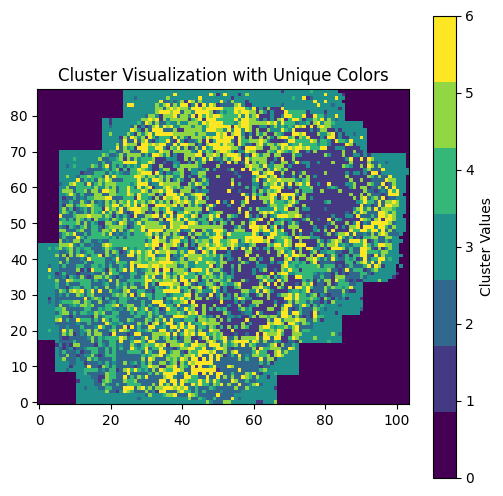

In [67]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()